# Otimização de Hiperparâmetros com Inferência Bayesiana

### Hiperparâmetro

Durante o treinamento do modelo lidamos com três tipos de dados:

- Dados de entrada. Esses dados configuram o modelo durante o treinamento para fazer predições precisas nos novos dados de interesse com características próximas. 

- Os parâmetros do modelo. São as variáveis escolhidas pelo modelo durante o processo de treinamento para ajustar os dados de entrada. 

    - Exemplo.: em uma rede neural cada nó tem um valor de peso que informa ao modelo o impacto dele na prdição final. Esses pesos são calculados com base nos dados de entrada e de muitas formas são a representação do modelo em si.
    
- Hiperparâmetros: são as variáveis que controlam o processo de treinamento e portante são decididas no momento da configuração do modelo.

    - Exemplo.: em uma rede neural profunda a quantidade de camadas profundas bem com a quantidade de nós são exemplos de hiperparâmetros do modelo.


## Otimização de Hiperparâmetros


Um modelo de Machine Learnig se utiliza de um dos três tipos de aprendizado (supervisionado, não supervisionado e aprendizado por reforço) para encontrar os melhores conjuntos de parâmetros que o compõe. Contudo parâmetros externos a esse aprendizado (hiperparâmetros do modelo) devem ser definidos antes do seu treinamento. 

Quando o domíno dos hiperparâmetros do modelo produz uma quantidade grande de combinações a serem testadas, a sua otimização se torna custosa com as técnicas mais convencionais, *Grid Search* e *Random Search*, pois elas testam as combinações possíveis dos parâmetros sem acompanhar as avaliações que já foram descartadas. Uma alternativa a essa abordagem é a **Otimização Bayesiana**, nela construímos um modelo de probabilidade da função objetivo e o usamos para encontrar a combinação ideal desses parâmetros. 

Nessa técnica buscamos encontrar as combinações de hiperparâmetros que maximizam/minimizam (dependendo da aplicação) a função objetivo, portanto precisamos balancear entre explorar regiões com alta variabilidade dos efeitos dos hiperparâmetros e focar nas regiões que temos maior conhecimento até o momento. Essa decisão é tomada com auxílio das **funções de aquisição**, que pode ser definida como uma heurística que define o próximo ponto a ser avaliado dado o modelo. A cada iteração, portanto, atualizamos o modelo com a obervação do ponto indicado pela função de aquisição.

Na literatura o modelo de probabilidade é chamado **Surrogate Model**, pois pode ser definido como $P(\mbox{score função objetivo | hiperparâmetros})$.

### Passos da implementação:

1. Inicie um modelo probabilístico da função objetivo real e uma função de aquisição associada
2. Para cada iteração encontre o par de hiperparâmetros que maximiza/minimiza a função de aquisição
3. Avalie os hiperparâmetros encontrados no passo 2 na função objetivo real 
4. Atualize o modelo probabilístico

## Implementações: Otimização Bayesiana com [skopt](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py)

Usaremos o Scikit-Optimize, biblioteca python de código aberto para otimização de hiperparâmetros que implementa vários métodos para otimização sequencial baseada em modelo.

Queremos encontrar $x^{*}$ tal que: $x^{*}=\mbox{argmax}_{x\in X}(f(x))$

onde, $f$ é uma função desconhecida e o processo de avaliação da mesma é custoso. Observe que dependendo da aplicação podemos minimizar ou maximizar

### Funções de Aquisição mais conhecidas:

- Expected improvement: $EI(x)=\mbox{agr max}_{x}E(\max(f(x_{t+1})-f(x^{*}),0))$

- Lower confidence bound: $\mu_{t}(x_{t+1})+ k * \sigma^{2}_{t}(x_{t+1})$

- Probability of improvement: $PI(x)=P(f(x)\geq f(x^{*})+\epsilon)$

onde $x^{*}$ é o melhor conjunto de hiperparâmetros até o momento.

As funções de aquisição controlam o trade-off entre exploration-exploitation usando um fator $k$ kappa de controle.

In [155]:
!pip install scikit-optimize -q

In [156]:
import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [157]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args

In [158]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score  

## Visualização dos conceitos usando a biblioteca gp_minimize

Suponha a **função objetivo**:

In [159]:
noise_level = 0.2

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))+ np.random.randn() * noise_level

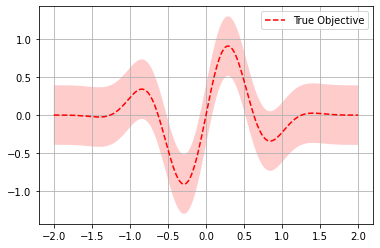

In [160]:
x = np.linspace(-2, 2, 200).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.figure(figsize=(6,4))
plt.plot(x, fx, "r--", label="True Objective")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],[fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Não precisamos entender o comportamento da função acima em todos os pontos, mas apenas encontrar o seu valor de mínimo. Para isso amostramos alguns pontos aleatórios e encontramos a distribuição de probabilidade desses pontos. Caso optemos por um modelo via um processo gaussiano, teremos como hipótese que cada ponto amostrado segue também uma distribuição normal. No skop, a otimização bayesiana é implementada pela classe `gp_minimize`

In [161]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=2,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

O mínimo dessa função é dado por:

In [162]:
print(f'valor mínimo:{np.round(res.x[0],2)}, função no ponto de mínimo:{np.round(res.fun,2)}')

valor mínimo:-0.2, função no ponto de mínimo:-1.17


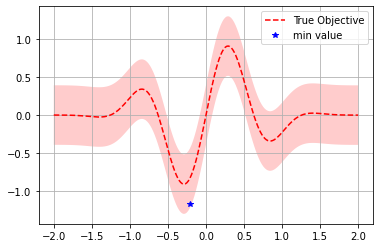

In [163]:
x = np.linspace(-2, 2, 200).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.figure(figsize=(6,4))
plt.plot(x, fx, "r--", label="True Objective")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],[fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.plot(res.x[0], res.fun, 'b*', label='min value')
plt.legend()
plt.grid()
plt.show()

Além disso, conseguimos encontrar o número de iterações necessárias para alcançarmos esse valor mínimo.

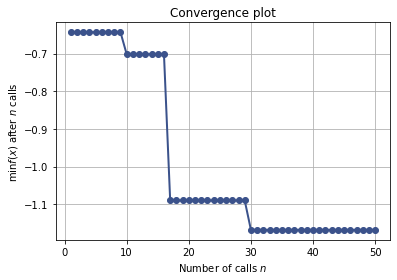

In [164]:
plt.rcParams["figure.figsize"] = (6,4)
plot_convergence(res);

## Visualização

- Aproximação do modelo baseado em um processo Gaussiano a função original (nos gráficos à esquerda).
- Função aquisição que determina o próximo ponto a ser observado (nos gráficos à direita) a cada vez que o surrogate model é regerado. 

- Observe que: 
    - o modelo GP próximo aos pontos avaliados apresenta uma variância próxima de zero. 
    - ao aumentar o número de iterações o modelo GP se aproxima da função real.
    - além disso os últimos pontos são clusterizados próximos ao último ponto observado porque o GP não tem nenhum ganho na exploração das vizinhanças de maior variabilidade.

In [165]:
def f_wo_noise(x):
    return f(x, noise_level=0)

In [166]:
def acquisition_functions_convergence(res, acq_func):
    plt.rcParams["figure.figsize"] = (6, 4)
    _ = plot_gaussian_process(res, objective=f_wo_noise,noise_level=noise_level);

In [167]:
def optimization_iteration_plot(res, acq_func_name, iter_num):
    for n_iter in range(iter_num):
        plt.rcParams["figure.figsize"] = (15, 10)
        
        plt.subplot(5, 2, 2*n_iter+1)

        if n_iter == 0:
            show_legend = True
        else:
            show_legend = False

        ax = plot_gaussian_process(res, n_calls=n_iter,
                                   objective=f_wo_noise,
                                   noise_level=noise_level,
                                   show_legend=show_legend, show_title=False,
                                   show_next_point=False, show_acq_func=False)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.title("Surrogate Model: Processo Gaussino")
        plt.tight_layout(pad=3.0)
        
        plt.subplot(5, 2, 2*n_iter+2)
        ax = plot_gaussian_process(res, n_calls=n_iter,
                                   show_legend=show_legend, show_title=False,
                                   show_mu=False, show_acq_func=True,
                                   show_observations=False,
                                   show_next_point=True)
        ax.set_ylabel("")
        ax.set_xlabel("")
    plt.title(f"Função de Aquisição: {acq_func_name}")
    plt.show()

#### Função de Aquisição: Expected improvement

In [168]:
acq_func="EI"

In [169]:
res = gp_minimize(f,[(-2.0, 2.0)],acq_func=acq_func,n_calls=15,n_random_starts=5,noise=0.1**2,random_state=1234)  

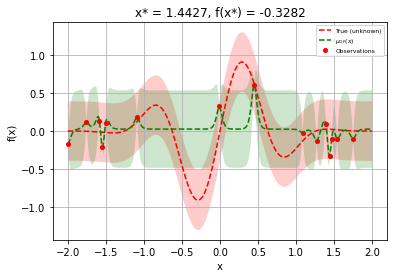

In [170]:
acquisition_functions_convergence(res, acq_func)

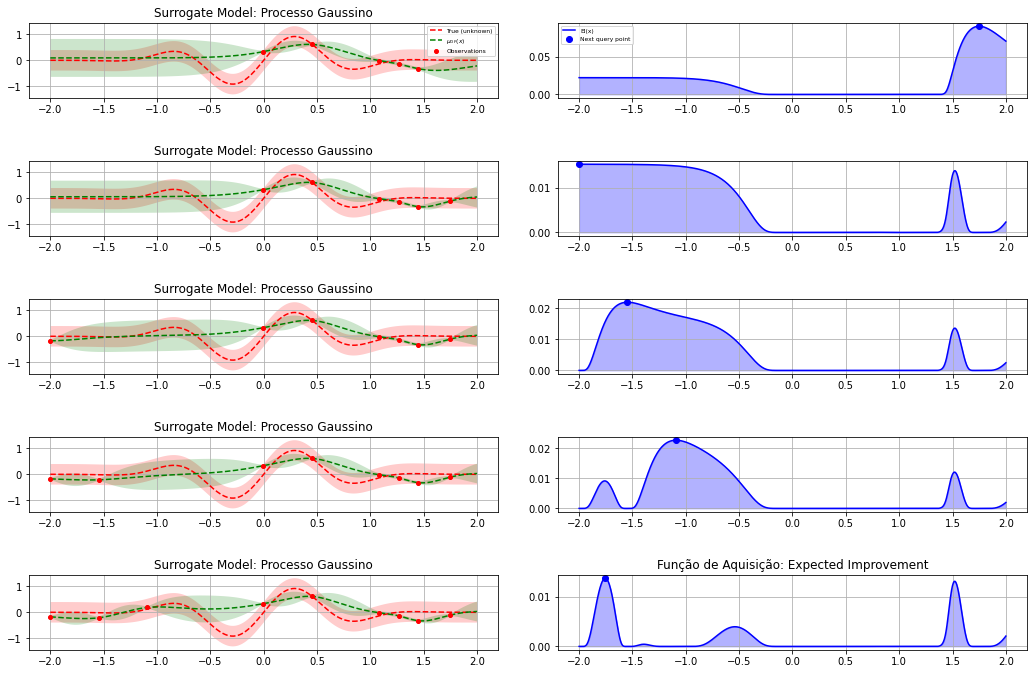

In [171]:
optimization_iteration_plot(res, "Expected Improvement", 5)

#### Função de Aquisição: Probability of Improvement

In [172]:
acq_func="PI"

In [173]:
res = gp_minimize(f,[(-2.0, 2.0)],acq_func=acq_func,n_calls=15,n_random_starts=5,noise=0.1**2,random_state=1234)  

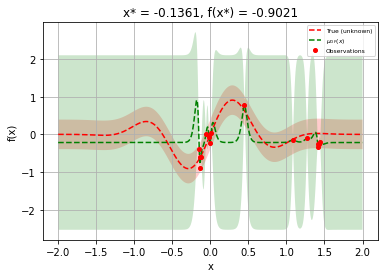

In [174]:
acquisition_functions_convergence(res, acq_func)

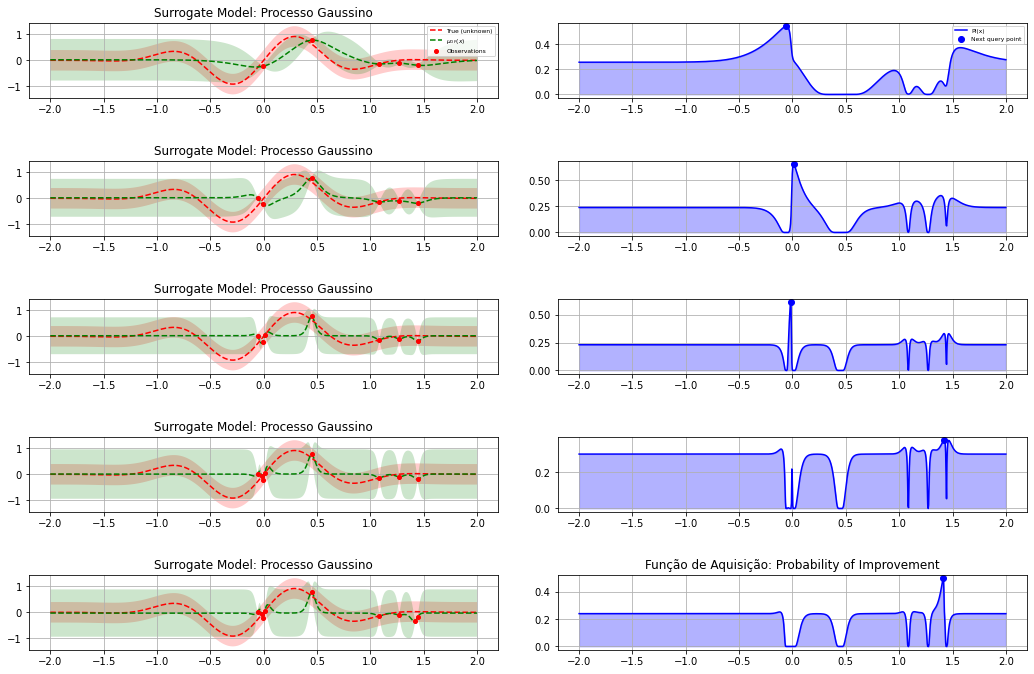

In [175]:
optimization_iteration_plot(res, "Probability of Improvement", 5)

#### Função de Aquisição: Lower Confidence Bound

In [176]:
acq_func="LCB"

In [177]:
res = gp_minimize(f,[(-2.0, 2.0)],acq_func=acq_func,n_calls=15,n_random_starts=5,noise=0.1**2,random_state=1234)  

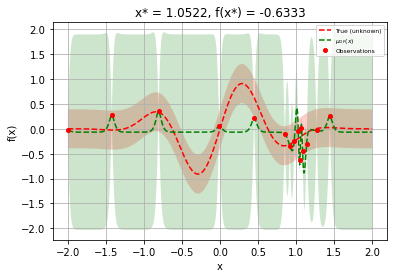

In [178]:
acquisition_functions_convergence(res, acq_func)

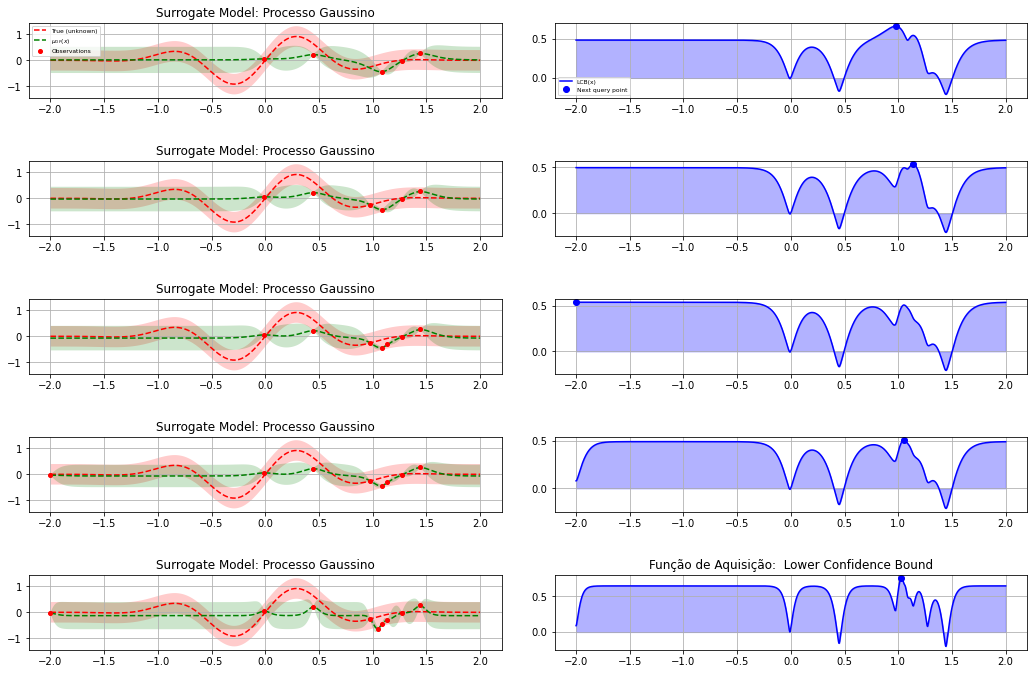

In [179]:
optimization_iteration_plot(res, " Lower Confidence Bound", 5)

## Exemplo usando Modelo Random Forest

#### Problema

Suponha que queiramos classificar os dados descritos abaixo por meio de um modelo Random Forest.

Cada ponto é uma imagem 8x8 de um dígito

|   |   |
| ------------------- | ------------------- |
|  Classes |  10 |
|  Samples per class |  ~180 |
|  Samples total |  1797 |
|  Dimensionality |  64 |
|  Features |  integers 0-16 |

In [180]:
##Dados
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

<Figure size 432x288 with 0 Axes>

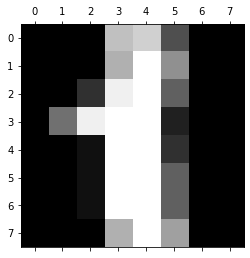

In [189]:
##Exemplo número 1
plt.rcParams["figure.figsize"] = (6, 4)
digits = load_digits()
pl.gray() 
pl.matshow(digits.images[1]) 
pl.show() 

### Otimização dos hiperparâmetros

#### Abordagem usando a biblioteca do BayesSearchCV

Essa classe pode ser usada da mesma maneira que GridSearchCV e RandomizedSearchCV no Scikit-Learn

In [182]:
%%time
opt = BayesSearchCV(
    RandomForestClassifier(),
    {'n_estimators': Integer(100,600, prior='log-uniform'),
    'max_depth': Integer(2,40, prior='uniform'),
    'min_samples_leaf': Integer(2,10, prior='uniform')},
    n_iter=32,
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train, y_train);

CPU times: user 2min 45s, sys: 3.25 s, total: 2min 48s
Wall time: 2min 34s


BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=32,
              scoring='accuracy',
              search_spaces={'max_depth': Integer(low=2, high=40, prior='uniform', transform='identity'),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=100, high=600, prior='log-uniform', transform='identity')})

In [183]:
print("Melhor pontuação nos dados de treino: %s" % opt.best_score_)
print("Melhor pontuação nos dados de teste:: %s" % opt.score(X_test, y_test))
print("Melhor combinação de parâmetros: %s" % opt.best_params_)

Melhor pontuação nos dados de treino: 0.9717891610987379
Melhor pontuação nos dados de teste:: 0.9755555555555555
Melhor combinação de parâmetros: OrderedDict([('max_depth', 13), ('min_samples_leaf', 2), ('n_estimators', 600)])


#### Abordagem usando a biblioteca gp_minimize (vista anteriormente)

In [184]:
search_space = list()
search_space.append(Integer(100,600, name='n_estimators', prior='uniform'))
search_space.append(Integer(2,40, name='max_depth', prior='log-normal'))
search_space.append(Integer(2,10, name='min_samples_leaf', prior='normal'))

In [185]:
@use_named_args(search_space)
def evaluate_model(**params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=3).mean()
    return -acc

In [186]:
%%time
result = gp_minimize(
    func=evaluate_model,
    dimensions=search_space,
    acq_func="EI",
    n_calls=100,
    random_state=42,
    n_jobs=1
)

CPU times: user 3min 52s, sys: 33.3 s, total: 4min 25s
Wall time: 5min 11s


In [187]:
print('Melhor pontuação nos dados de teste: %.3f' % -(result.fun)) 
print('Melhor combinação de parâmetros: %s' % (result.x))

Melhor pontuação nos dados de teste: 0.973
Melhor combinação de parâmetros: [108, 19, 2]


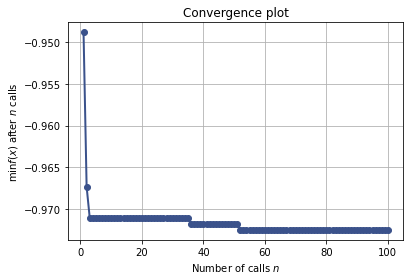

In [188]:
plt.rcParams["figure.figsize"] = (6,4)
plot_convergence(result) 